In [1]:
!python -c "import tvm; print('tvm installed properly!')"
!python -c "import mlc_llm; print('mlc_llm installed properly!')"

tvm installed properly!
mlc_llm installed properly!


In [2]:
!git clone --recursive https://github.com/mlc-ai/mlc-llm.git

Submodule path '3rdparty/argparse': checked out '557948f1236db9e27089959de837cc23de6c6bbd'
Submodule path '3rdparty/googletest': checked out '45804691223635953f311cf31a10c632553bbfc3'
Submodule path '3rdparty/stb': checked out 'ae721c50eaf761660b4f90cc590453cdb0c2acd0'
Submodule path '3rdparty/tokenizers-cpp': checked out '4bb753377680e249345b54c6b10e6d0674c8af03'
Submodule path '3rdparty/tokenizers-cpp/msgpack': checked out '8c602e8579c7e7d65d6f9c6703c9699db3fb0488'
Submodule path '3rdparty/tokenizers-cpp/sentencepiece': checked out 'f2219b53e24ff5deee4cacdc2d0ca3074e529a07'
Submodule path '3rdparty/tvm': checked out '9c894f78fdef156263ced19eed67e79203ca4a11'
Submodule path '3rdparty/tvm/3rdparty/OpenCL-Headers': checked out 'b590a6bfe034ea3a418b7b523e3490956bcb367a'
Submodule path '3rdparty/tvm/3rdparty/cnpy': checked out '4e8810b1a8637695171ed346ce68f6984e585ef4'
Submodule path '3rdparty/tvm/3rdparty/cutlass': checked out 'bbe579a9e3beb6ea6626d9227ec32d0dae119a49'
Submodule path '3r

Cloning into 'mlc-llm'...
Submodule '3rdparty/argparse' (https://github.com/p-ranav/argparse) registered for path '3rdparty/argparse'
Submodule '3rdparty/googletest' (https://github.com/google/googletest.git) registered for path '3rdparty/googletest'
Submodule '3rdparty/stb' (https://github.com/nothings/stb.git) registered for path '3rdparty/stb'
Submodule '3rdparty/tokenizers-cpp' (https://github.com/mlc-ai/tokenizers-cpp) registered for path '3rdparty/tokenizers-cpp'
Submodule '3rdparty/tvm' (https://github.com/mlc-ai/relax.git) registered for path '3rdparty/tvm'
Submodule '3rdparty/xgrammar' (https://github.com/mlc-ai/xgrammar.git) registered for path '3rdparty/xgrammar'
Cloning into 'C:/Users/MIRO1/AI Translation/web-llm/mlc-llm/3rdparty/argparse'...
Cloning into 'C:/Users/MIRO1/AI Translation/web-llm/mlc-llm/3rdparty/googletest'...
Cloning into 'C:/Users/MIRO1/AI Translation/web-llm/mlc-llm/3rdparty/stb'...
Cloning into 'C:/Users/MIRO1/AI Translation/web-llm/mlc-llm/3rdparty/token

## Define the GPT-2 Model

Create a `gpt2` folder under `mlc-llm/python/mlc_llm/model/`. It's structure will look like the following:

```
mlc-llm/python/mlc_llm/model/gpt2/
├── gpt2_loader.py          # Load and convert the weights from Huggingface
├── gpt2_model.py           # Define the model architecture and configuration
├── gpt2_quantization.py    # Define quantization schemes
└── __init__.py
```

We first focus on `gpt2_model.py`. This file defines the GPT-2 model architecture in a modularized fashion using `tvm.relax.frontend.nn.Module`, similar to the PyTorch counterpart.

### Define a Config Class in gpt2_model.py

Let's first define a config class that is almost a direct translation from Huggingface's [GPT2Config](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/configuration_gpt2.py). The attributes of this class should have the same name as the corresponding attributes in the huggingface config, otherwise, the huggingface config won't be loaded properly.

The `__post_init__` function is called after all the dataclass attributes are initialized.

In [ ]:
import dataclasses
import math

from mlc_llm.support.config import ConfigBase

from tvm import te, tir
from tvm.relax.frontend import nn
from tvm.relax.frontend.nn import Tensor, op
from typing import Any, Dict, Optional

@dataclasses.dataclass
class GPT2Config(ConfigBase):  # pylint: disable=too-many-instance-attributes
    """Configuration of the GPT-2 model."""

    vocab_size: int
    n_embd: int
    n_layer: int
    n_head: int
    layer_norm_epsilon: int
    n_inner: int = -1
    scale_attn_by_inverse_layer_idx: bool = False
    # Internal configs used by MLC-LLM
    context_window_size: int = 0
    prefill_chunk_size: int = 0
    kwargs: Dict[str, Any] = dataclasses.field(default_factory=dict)

    def __post_init__(self):
        if self.n_inner is None or self.n_inner == -1:
            self.n_inner = 4 * self.n_embd

        self.context_window_size = self.kwargs["n_positions"]

        # Internal configs initialization

### Define model architecture in gpt2_model.py

With `tvm.relax.frontend.nn.Module`, we are able to define the model architecture in a modularized fashion. It looks pretty similar to the PyTorch style, except that the forward function does not actually perform the computation. It traces the operator graph using the placeholders that are passed as inputs.

Here we only present the GPT2Attention module. The entire model definition can be found [here](https://github.com/mlc-ai/mlc-llm/blob/main/python/mlc_llm/model/gpt2/gpt2_model.py).

You can optionally use `op._print(some_tensor)` to print out intermediate values of a tensor when running the compiled module. If you do this, you have to specify `debug=True` in `export_tvm()` and `jit()`. In addition to manual printing, we also provide an end-to-end debugging module `DebugChat` that will automatically dump intermediate values from all layers. Please refer to the
[Debug Compiled MLC Model with DebugChat](#Debug-Compiled-MLC-Model-with-DebugChat) section below.

In [ ]:
class GPT2Attention(nn.Module):  # pylint: disable=too-many-instance-attributes
    def __init__(self, config: GPT2Config):
        self.embed_dim = config.n_embd
        self.num_heads = config.n_head // config.tensor_parallel_shards
        self.head_dim = config.head_dim
        self.scale_attn_by_inverse_layer_idx = config.scale_attn_by_inverse_layer_idx

        self.c_attn = nn.Linear(
            in_features=self.embed_dim,
            out_features=3 * self.num_heads * self.head_dim,
            bias=True,
        )
        self.c_proj = nn.Linear(self.num_heads * self.head_dim, self.embed_dim, bias=True)

    def forward(self, hidden_states: Tensor, paged_kv_cache: PagedKVCache, layer_id: int):
        d, h = self.head_dim, self.num_heads
        b, s, _ = hidden_states.shape

        qkv = self.c_attn(hidden_states)
        qkv = op.reshape(qkv, (b, s, 3 * h, d))

        if self.scale_attn_by_inverse_layer_idx:
            attn_score_scaling_factor = 1.0 / float(layer_id + 1)
        else:
            attn_score_scaling_factor = 1.0

        # Attention
        output = op.reshape(
            paged_kv_cache.attention_with_fused_qkv(
                layer_id, qkv, self.num_heads, attn_score_scaling_factor
            ),
            (b, s, h * d),
        )
        return self.c_proj(output)

Note that we have already provided some built-in common modules that you will find handy. For example, the `nn.Linear` and `nn.KVCache` modules here are all built-in modules in MLC-LLM. A full list of built-in modules can be found [here](https://github.com/apache/tvm/blob/unity/python/tvm/relax/frontend/nn/modules.py).

Similarly, we have also provided a lot of common built-in operations that operates on the Tensors. For example, `op.reshape`, `op.matmul`, `op.softmax`, etc.A full list of built-in operations can be found [here](https://github.com/apache/tvm/blob/unity/python/tvm/relax/frontend/nn/op.py).

### Defining a Model Spec with `nn.spec`

Once we verified each layer of the model behaves correctly, we are ready to write a model spec to convert the model from `nn.module` to TVM IRModule.

In `get_default_spec` function, we need to define a model spec as follows:

```
def get_default_spec(self):
        mod_spec = {
            "embed": {
                "input_ids": nn.spec.Tensor(["seq_len"], "int32"),
                "$": {
                    "param_mode": "packed",
                    "effect_mode": "none",
                },
            },
            "prefill": {
                "input_embed": nn.spec.Tensor([1, "seq_len", self.n_embed], self.dtype),
                "paged_kv_cache": nn.spec.Object(object_type=PagedKVCache),
                "$": {
                    "param_mode": "packed",
                    "effect_mode": "none",
                },
            },
            "decode": {
                "input_embed": nn.spec.Tensor([1, 1, self.n_embed], self.dtype),
                "paged_kv_cache": nn.spec.Object(object_type=PagedKVCache),
                "$": {
                    "param_mode": "packed",
                    "effect_mode": "none",
                },
            },
            "batch_prefill": {
                "input_embeds": nn.spec.Tensor([1, "seq_len", self.n_embed], self.dtype),
                "logit_positions": nn.spec.Tensor(["batch_size"], "int32"),
                "paged_kv_cache": nn.spec.Object(object_type=PagedKVCache),
                "$": {
                    "param_mode": "packed",
                    "effect_mode": "none",
                },
            },
            "batch_decode": {
                "input_embeds": nn.spec.Tensor(["batch_size", 1, self.n_embed], self.dtype),
                "paged_kv_cache": nn.spec.Object(object_type=PagedKVCache),
                "$": {
                    "param_mode": "packed",
                    "effect_mode": "none",
                },
            },
            "batch_verify": {
                "input_embeds": nn.spec.Tensor([1, "seq_len", self.n_embed], self.dtype),
                "paged_kv_cache": nn.spec.Object(object_type=PagedKVCache),
                "$": {
                    "param_mode": "packed",
                    "effect_mode": "none",
                },
            },
            "create_paged_kv_cache": {
                "max_batch_size": int,
                "max_total_seq_len": int,
                "prefill_chunk_size": int,
                "page_size": int,
                "support_sliding_window": int,
                "$": {
                    "param_mode": "none",
                    "effect_mode": "none",
                },
            },
        }
        return nn.spec.ModuleSpec.from_raw(mod_spec, self)
```

All the specified methods, e.g., `embed`, `prefill`, `decode`, etc. will be exported to TVM IRModule. We support `nn.spec.Tensor`, `nn.spec.Tuple` and integers as relax function inputs.

Difference between "default" and "packed" calling convention can be found below:

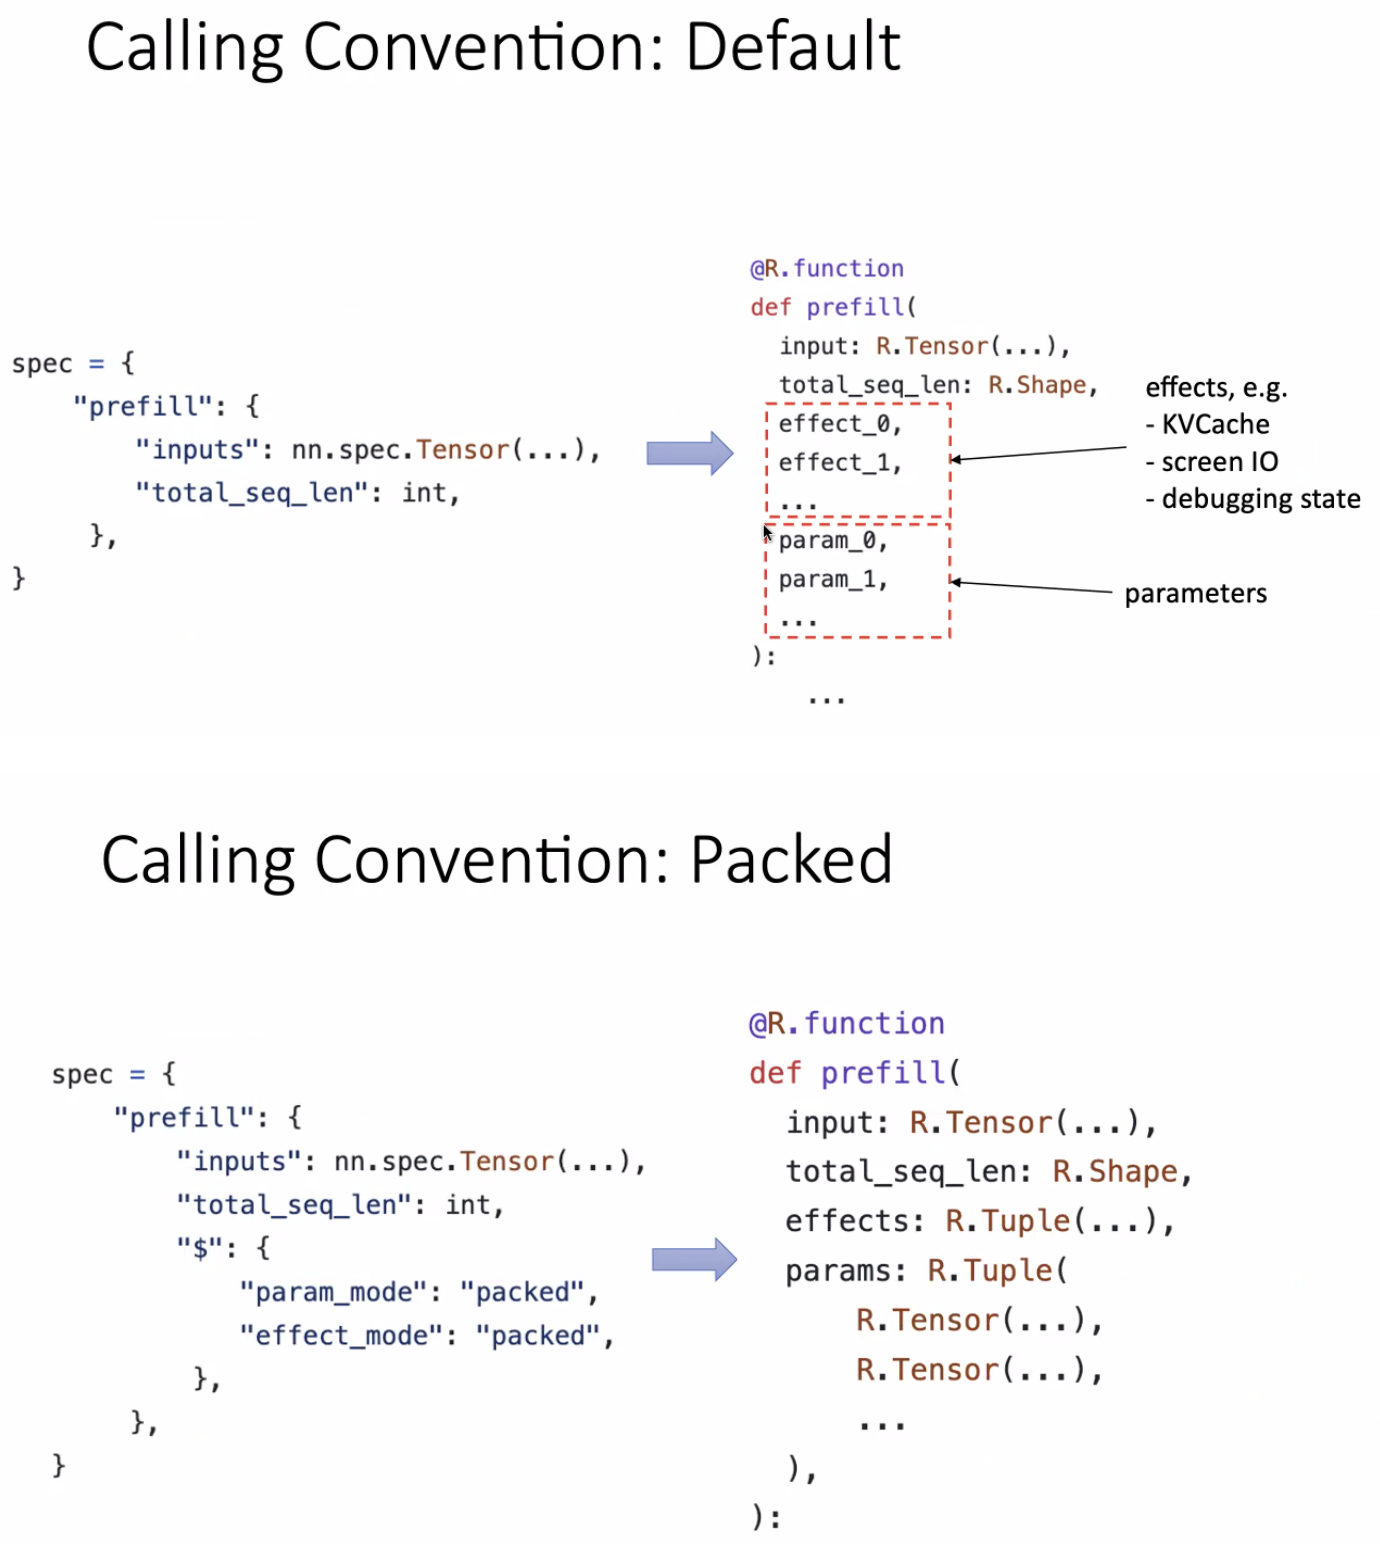

After providing the model spec, we can easily convert the TVM nn.module to relax Tensor IR using `export_tvm` function. We can view the entire model in Tensor IR, and the entire list of model parameter names and dtypes.

In [ ]:
from mlc_llm.model.gpt2 import gpt2_model

config_dict = {
    "architectures": ["GPT2LMHeadModel"],
    "bos_token_id": 50256,
    "eos_token_id": 50256,
    "hidden_act": "gelu_new",
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_layer": 12,
    "n_positions": 1024,
    "layer_norm_epsilon": 1e-05,
    "scale_attn_by_inverse_layer_idx": False,
    "vocab_size": 50257,
}

config = gpt2_model.GPT2Config.from_dict(config_dict)
model = gpt2_model.GPT2LMHeadModel(config)
mod, named_params = model.export_tvm(
    spec=model.get_default_spec(),
)

# Uncomment the following line to show the model in Tensor IR
# mod.show(black_format=False)

for name, param in named_params:
    print(name, param.shape, param.dtype)

### Define a Loader in gpt2_loader.py

In `gpt2_loader.py`, we define how we convert the parameters from Huggingface to the format used by MLC model.

The loader class will return an [`ExternMapping`](https://github.com/mlc-ai/mlc-llm/blob/main/python/mlc_llm/loader/mapping.py) that contains two kinds of mappings:
- Source -> MLC parameter mapping: for example, parameter renaming, parameter transformation, etc.
- Unused mapping: parameters in the source that are not used in the MLC model definition.

In GPT2, we need to transpose c_attn, c_proj and c_fc weights since GPT-2 uses Conv1D. To do so, we will supply a mapping function as follows

```
for conv1d_weight_name in ["attn.c_attn", "attn.c_proj", "mlp.c_proj", "mlp.c_fc"]:
    src_name = f"h.{i}.{conv1d_weight_name}.weight"
    mlc_name = f"transformer.{src_name}"
    mapping.add_mapping(
        mlc_name,
        [src_name],
        functools.partial(
            lambda x, dtype: x.transpose().astype(dtype),
            dtype=named_parameters[mlc_name].dtype,
        ),
    )
```

Some renamings are also needed for GPT-2 parameters conversion to work. Please refer to [gpt2_loader.py](https://github.com/mlc-ai/mlc-llm/blob/main/python/mlc_llm/model/gpt2/gpt2_loader.py).

## Add the Model to the Supported Pre-built Model Workflow

Once the entire model is defined in TVM nn.module, including the model architecture, model loader and model quantitizer, we can then add it to the supported pre-built model workflow.

In [`mlc-llm/python/mlc_llm/model/model.py`](https://github.com/mlc-ai/mlc-llm/blob/main/python/mlc_llm/model/model.py), add the GPT-2 model to the `MODELS` list:

```
"gpt2": Model(
    name="gpt2",
    model=gpt2_model.GPT2LMHeadModel,
    config=gpt2_model.GPT2Config,
    source={
        "huggingface-torch": gpt2_loader.huggingface,
        "huggingface-safetensor": gpt2_loader.huggingface,
    },
    quantize={
        "no-quant": gpt2_quantization.no_quant,
        "group-quant": gpt2_quantization.group_quant,
    },
)
```

## Compile GPT-2 model libraries and weights

The following steps will be the same as the general model compilation workflow [here](https://llm.mlc.ai/docs/compilation/compile_models.html).

In [ ]:
# Create directory
!mkdir -p dist/models
%cd dist/models

# Clone HF weights
!git lfs install
!git clone https://huggingface.co/gpt2
%cd ../..

In [ ]:
# Convert weight
!mlc_llm convert_weight ./dist/models/gpt2/ --device cuda --quantization q0f16 -o dist/gpt2-q0f16-MLC

In [ ]:
# 1. gen_config: generate mlc-chat-config.json and process tokenizers
!mlc_llm gen_config ./dist/models/gpt2 \
    --quantization q0f16 --conv-template gpt2 \
    -o dist/gpt2-q0f16-MLC/

# 2. compile: compile model library with specification in mlc-chat-config.json
!mlc_llm compile ./dist/gpt2-q0f16-MLC/mlc-chat-config.json \
    --device cuda -o dist/gpt2-q0f16-MLC/gpt2-q0f16-cuda.so

## Debug Compiled MLC Model with DebugChat

After successfully compiling the model library and converting the model weights, it is important to check whether the model generates the correct output. One way to check this is to compare the output logits of the model with its Huggingface PyTorch counterpart under the same input tokens.

To help with debugging the MLC model, we provide a `mlc_llm.testing.DebugChat` module that

- Loads the MLC model we just compiled
- Runs the entire `forward` flow of the model using a user-specified prompt
- Dumps the intermediate values from all layers.

You can then compare the intermediate values with those from the Huggingface PyTorch model. (For PyTorch, you can extract intermediate values using [`register_forward_hook`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook))

In [ ]:
!python -m mlc_llm.testing.debug_chat --model ./dist/gpt2-q0f16-MLC/ --model-lib dist/gpt2-q0f16-MLC/gpt2-q0f16-cuda.so --device cuda --debug-dir ./debug-gpt2 --generate-len 5 "Hey how are you doing today?"

The intermediate outputs are dumped to `debug-gpt2` folder. For each prefill/decode stage, there is a separate folder that contains `.npz` files storing the arguments of each kernel function call.

For example: `./debug-gpt2/decode_2/f0_take3.npz` corresponds to the 0th `take` function call at the 2nd decode step. The output logits are saved to `logits.npz`.

**NOTE** Because of the Destination-Passing Style (See [here](https://mlc.ai/chapter_end_to_end/index.html#call-dps-packed-construct)) of TIR function calls, each function call arguments will look like the following:

```
def low_level_prim_func(in0, in1, ..., out):
    # implementations
```
Therefore, the last argument of the function call will be the output.


The `.npz` files can be loaded as follows

In [ ]:
import numpy as np

data = np.load('./debug-gpt2/decode_2/f0_take3.npz')
print(data)
print(data["arg_0"])
print(data["arg_1"])
print(data["arg_2"]) # This is the output of the take function